In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime, zipfile
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# function to load the image in the form of tensors.
def load_image(img_path):
    img = tf.io.read_file(tf.strings.join([img_path])) # Ensure img_path is a string
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [384, 384], antialias=True)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img


In [4]:

def data_path(clear_img_dir, hazy_img_dir):

    train_img = []
    val_img = []

    clear_img_paths = glob.glob(os.path.join(clear_img_dir, '*.jpg'))
    hazy_img_paths = glob.glob(os.path.join(hazy_img_dir, '*.jpg'))

    n = len(clear_img_paths)
    random.shuffle(clear_img_paths)

    train_keys = clear_img_paths[:int(0.9*n)]  # 90% data for train, 10% for val
    val_keys = clear_img_paths[int(0.9*n):]

    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'

    for hazy_path in hazy_img_paths:
        img_name = os.path.basename(hazy_path)  # Extracting filename from the path
        clear_path = os.path.join(clear_img_dir, img_name.split('_')[0] + '.jpg')  # Constructing clear image path
        if clear_path in split_dict:  # Checking if the clear image path exists in split_dict
            if split_dict[clear_path] == 'train':
                train_img.append([hazy_path, clear_path])  # Adding hazy and clear image paths to train_img
            else:
                val_img.append([hazy_path, clear_path])  # Adding hazy and clear image paths to val_img

    return train_img, val_img


In [5]:
train_data , val_data = data_path(clear_img_dir = r"C:\Users\ASUS\Downloads\clear_images", hazy_img_dir = r"C:\Users\ASUS\Downloads\haze")
print("loaded")
print(len(train_data)+len(val_data))
# "C:\Users\DEEPAK YADAV\Downloads\Image dehazer\clear_images\0022.jpg"

loaded
13023


In [6]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
    # containing tensor representation of images. from function load_images.
    # after tensor_slicing train_data_orig becomes a TensorFlow dataset that can be used for various operations, 
    # such as batching, shuffling, and iterating, typically for training machine learning models.
    # TensorFlow Datasets is a collection of datasets ready to use, with TensorFlow or 
    # other Python ML frameworks, such as Jax. All datasets are exposed as tf.data.Datasets , 
    # enabling easy-to-use and high-performance input pipelines. To get started see the guide and our list of datasets.
    
#     train_data_haze = []
#     train_data_orig = []
#     for img_pair in train_data:
#         haze_img_path = img_pair[0]
#         orig_img_path = img_pair[1]
#         haze_img_tensor = load_image(haze_img_path)
#         orig_img_tensor = load_image(orig_img_path)
#         train_data_haze.append(haze_img_tensor)
#         train_data_orig.append(orig_img_tensor)

#     train = tf.data.Dataset.from_tensor_slices((train_data_haze, train_data_orig))
#     train = train.shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)

    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)
#     "train" now represents a TensorFlow dataset containing batches of paired hazy and original image tensors, shuffled and ready for training.

#     val_data_haze = []
#     val_data_orig = []
#     for img_pair in val_data:
#         haze_img_path = img_pair[0]
#         orig_img_path = img_pair[1]
#         haze_img_tensor = load_image(haze_img_path)
#         orig_img_tensor = load_image(orig_img_path)
#         val_data_haze.append(haze_img_tensor)
#         val_data_orig.append(orig_img_tensor)

#     val = tf.data.Dataset.from_tensor_slices((val_data_haze, val_data_orig))
#     val = val.shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)

    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)
    
    return train, val

In [7]:
dataloader(train_data, val_data, 8)


(<BatchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None))>)

In [8]:
# function to display output.

def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,12))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

In [34]:
def haze_net():
  inputs = tf.keras.Input(shape = [384, 384, 3]) 
  conv1 = Conv2D(3,1,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=k_init,
                kernel_regularizer=regularizer)(inputs)
  conv2 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=k_init,
                kernel_regularizer=regularizer)(conv1)
  concat1 = tf.concat([conv1,conv2],axis=-1)
  
  conv3 = Conv2D(3,5,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=k_init,
                kernel_regularizer=regularizer)(concat1)
  concat2 = tf.concat([conv2,conv3],axis=-1)
  
  conv4 = Conv2D(3,7,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=k_init,
                kernel_regularizer=regularizer)(concat2)
  concat3 = tf.concat([conv1,conv2,conv3,conv4],axis=-1)
  
  conv5 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=k_init,
                kernel_regularizer=regularizer)(concat3)
  K = conv5
  
  output = ReLU(max_value=1.0)(tf.math.multiply(K,inputs) - K + 1.0)
  # output = output / 255.0
  
  return Model(inputs = inputs, outputs = output)

In [35]:
from tensorflow.keras.optimizers import Adam
epochs = 150
batch_size = 8
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data, val_data = data_path(clear_img_dir = r"C:\Users\ASUS\Downloads\clear_images", hazy_img_dir = r"C:\Users\ASUS\Downloads\haze")
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net = haze_net()

train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks to record metrics
checkpoint_callback = ModelCheckpoint(filepath=r'C:\Users\ASUS\Downloads\Video\model_checkpoint2.h5', monitor='val_loss', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Compile the model
net.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['accuracy'])

# Train the model and record metrics
history = net.fit(
    train,
    epochs=epochs,
    validation_data=val,
    callbacks=[checkpoint_callback, early_stopping_callback],
    batch_size=batch_size
)

Epoch 1/150
740/740 [==============================] - 323s 432ms/step - loss: 0.0100 - accuracy: 0.8637 - val_loss: 0.0114 - val_accuracy: 0.8523
Epoch 2/150
740/740 [==============================] - 322s 434ms/step - loss: 0.0100 - accuracy: 0.8637 - val_loss: 0.0114 - val_accuracy: 0.8523
Epoch 3/150
740/740 [==============================] - 318s 429ms/step - loss: 0.0100 - accuracy: 0.8637 - val_loss: 0.0114 - val_accuracy: 0.8523
Epoch 4/150
740/740 [==============================] - 310s 418ms/step - loss: 0.0100 - accuracy: 0.8637 - val_loss: 0.0114 - val_accuracy: 0.8523
Epoch 5/150
740/740 [==============================] - 309s 417ms/step - loss: 0.0100 - accuracy: 0.8637 - val_loss: 0.0114 - val_accuracy: 0.8523
Epoch 6/150
740/740 [==============================] - 307s 414ms/step - loss: 0.0100 - accuracy: 0.8637 - val_loss: 0.0114 - val_accuracy: 0.8523
Epoch 7/150
740/740 [==============================] - 303s 410ms/step - loss: 0.0100 - accuracy: 0.8637 - val_loss: 0

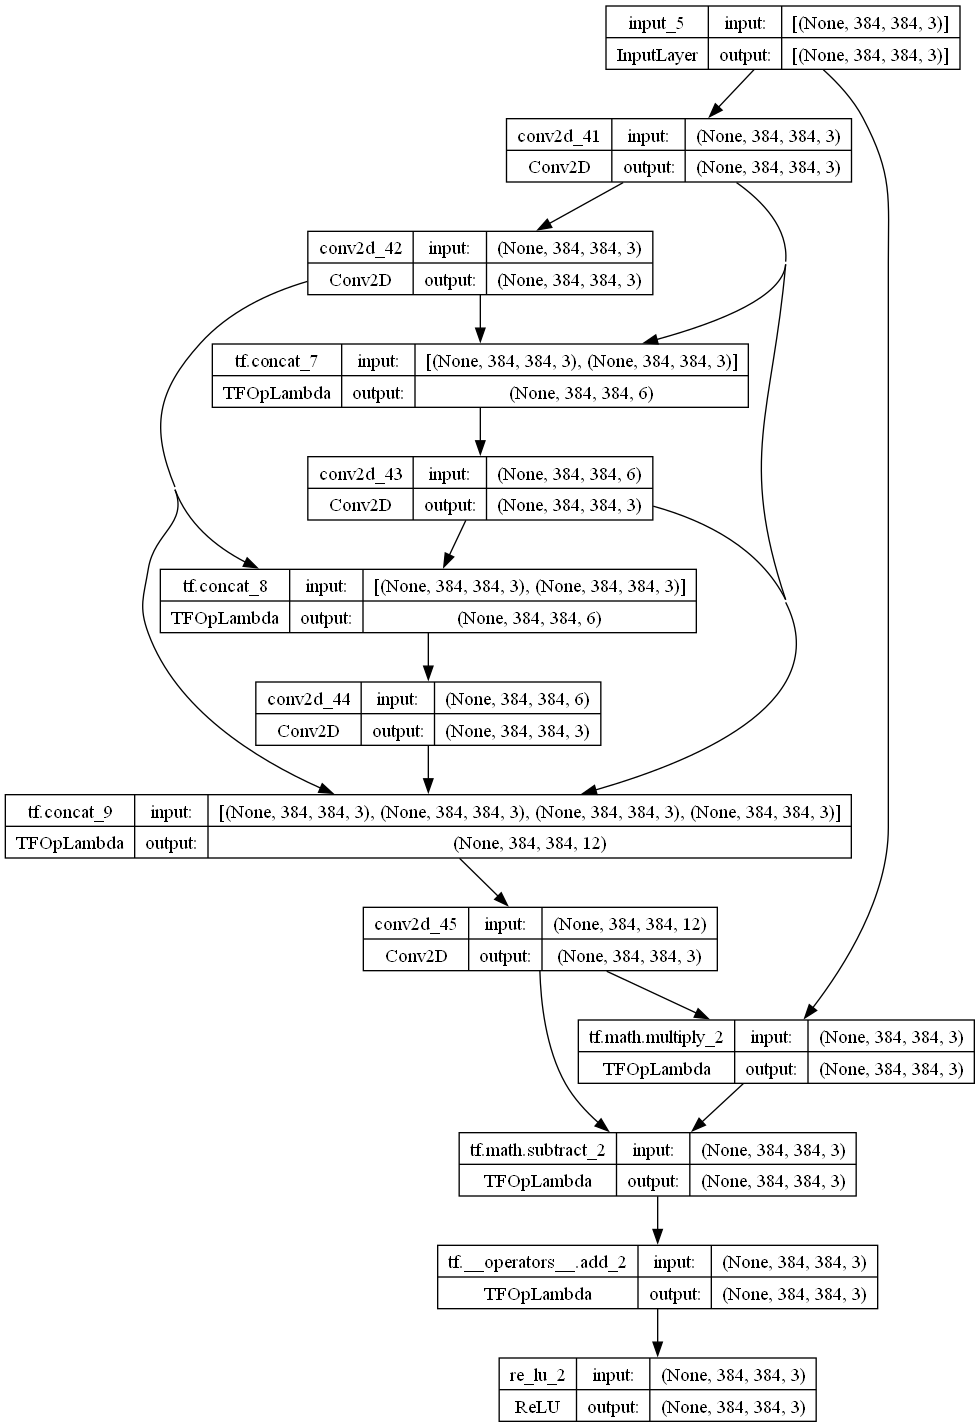

In [57]:
# without attention
plot_model(net, to_file = r"C:\Users\ASUS\Downloads\haze_net2.png",show_shapes= True,show_layer_names=True)

In [58]:
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 384, 384, 3)  12          ['input_5[0][0]']                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 384, 384, 3)  84          ['conv2d_41[0][0]']              
                                                                                                  
 tf.concat_7 (TFOpLambda)       (None, 384, 384, 6)  0           ['conv2d_41[0][0]',        

In [59]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, to_file = None):

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))
    if to_file:
        plt.savefig(to_file)

    # Add legend to the plot.
    plt.legend()

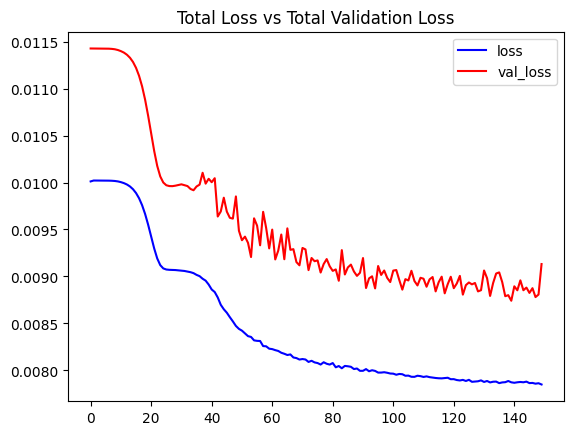

In [60]:
    # # Visualize the training and validation loss metrices.
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss', to_file = r"C:\Users\ASUS\Downloads\Video\loss2.png")

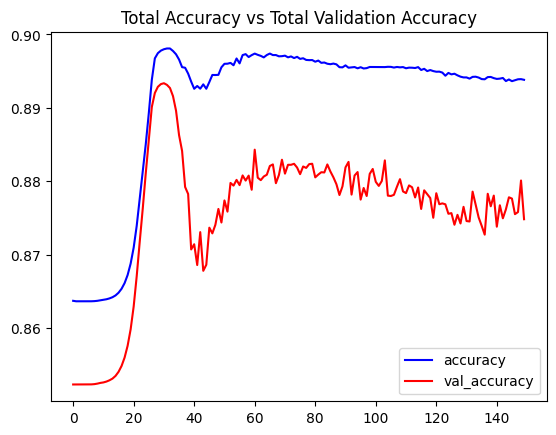

In [61]:
# Visualize the training and validation accuracy metrices.
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy', to_file = r"C:\Users\ASUS\Downloads\Video\accuracy2.png")

In [62]:
model_file_name = r'C:\Users\ASUS\Downloads\Video\haze_net_3.h5'
net.save(model_file_name)
net.save(r'C:\Users\ASUS\Downloads\Video\haze_net_trained2')

INFO:tensorflow:Assets written to: C:\Users\ASUS\Downloads\Video\haze_net_trained2\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\Downloads\Video\haze_net_trained2\assets


In [36]:
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 384, 384, 3)  12          ['input_5[0][0]']                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 384, 384, 3)  84          ['conv2d_41[0][0]']              
                                                                                                  
 tf.concat_7 (TFOpLambda)       (None, 384, 384, 6)  0           ['conv2d_41[0][0]',        

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Define model checkpoint callback to save the best model
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    
    history = {'train_loss': [], 'val_loss': []}  # Store training history
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        
        # training loop
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):
            with tf.GradientTape() as tape:
                train_logits = net(train_batch_haze, training=True)
                loss = mean_squared_error(train_batch_orig, train_logits)
            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))
            train_loss_tracker.update_state(train_batch_orig, train_logits)
        
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        for val_batch_haze, val_batch_orig in val:
            val_logits = net(val_batch_haze, training=False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
        
        print(' - Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print(' - Time taken: %.2fs' % (time.time() - start_time_epoch))
        
        # Store training history
        history['train_loss'].append(train_loss_tracker.result().numpy())
        history['val_loss'].append(val_loss_tracker.result().numpy())
        
        # Reset metrics for next epoch
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()
        
        # Check early stopping criteria
        if epoch > 0:
            if history['val_loss'][-1] >= history['val_loss'][-2]:
                print("Validation loss didn't improve. Early stopping...")
                break  # Stop training
        
        net.save('trained_model')  # Save the model (variables, weights, etc)
    
    return history

In [38]:
history = train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 Training Loss: 0.0722 - Validation Loss: 0.0118 - Time taken: 308.30s


INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets



Start of epoch 1 Training Loss: 0.0102 - Validation Loss: 0.0108 - Time taken: 332.34s


INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets



Start of epoch 2 Training Loss: 0.0096 - Validation Loss: 0.0106 - Time taken: 334.93s


INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets



Start of epoch 3 Training Loss: 0.0094 - Validation Loss: 0.0106 - Time taken: 330.23s


INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets



Start of epoch 4 Training Loss: 0.0093 - Validation Loss: 0.0104 - Time taken: 335.49s


INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets



Start of epoch 5 Training Loss: 0.0092 - Validation Loss: 0.0103 - Time taken: 334.09s


INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets



Start of epoch 6 Training Loss: 0.0091 - Validation Loss: 0.0104 - Time taken: 333.80s
Validation loss didn't improve. Early stopping...


In [44]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, to_file = None):

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))
    if to_file:
        plt.savefig(to_file)

    # Add legend to the plot.
    plt.legend()

In [47]:
# # Visualize the training and validation loss metrices.
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss', to_file = r"C:\Users\ASUS\Downloads\Video\loss.png")

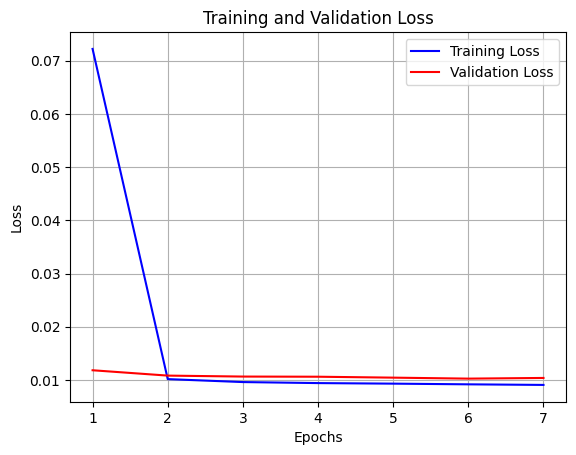

In [51]:
import matplotlib.pyplot as plt

def plot_loss_curve(history):
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    
    epochs = range(1, len(train_loss) + 1)
    
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid lines
    plt.show()

# Call the function to plot the loss curves
plot_loss_curve(history)


In [63]:
def evaluate(net, test_img_path, save_path):
    test_img = glob.glob(test_img_path + '/*.jpg')
    random.shuffle(test_img)
    output_images = []

    for idx, img_path in enumerate(test_img):

        img = tf.io.read_file(img_path)
        img = tf.io.decode_jpeg(img, channels=3)

        if img.shape[1] > img.shape[0]:
            img = tf.image.resize(img, size=(384, 384), antialias=True)
        if img.shape[1] < img.shape[0]:
            img = tf.image.resize(img, size=(384, 384), antialias=True)

        img = img / 255
        img = tf.expand_dims(img, axis=0)  # transform input image from 3D to 4D

        dehaze = net(img, training=False)
        dehaze_image = tf.keras.preprocessing.image.array_to_img(dehaze[0])

        # Extract filename from input image path
        filename = os.path.basename(img_path)
        prefix = filename[:4]
        output_filename = f"{prefix}_dehazed"  # Use the same filename for output image

        # Save the dehazed image with the same filename
        save_file_path = os.path.join(save_path, output_filename)
        dehaze_image.save(save_file_path, format='JPEG')

        # Append the saved image path to the list
        output_images.append(save_file_path)
        plt.figure(figsize=(80, 80))

        display_list = [img[0], dehaze[0]]  # make the first dimension zero
        title = ['Hazy Image', 'Dehazed Image']

        for i in range(2):
            plt.subplot(1, 2, i + 1)
            plt.title(title[i], fontsize=65, y=1.045)
            plt.imshow(display_list[i])
            plt.axis('off')

        plt.show()

    return output_images

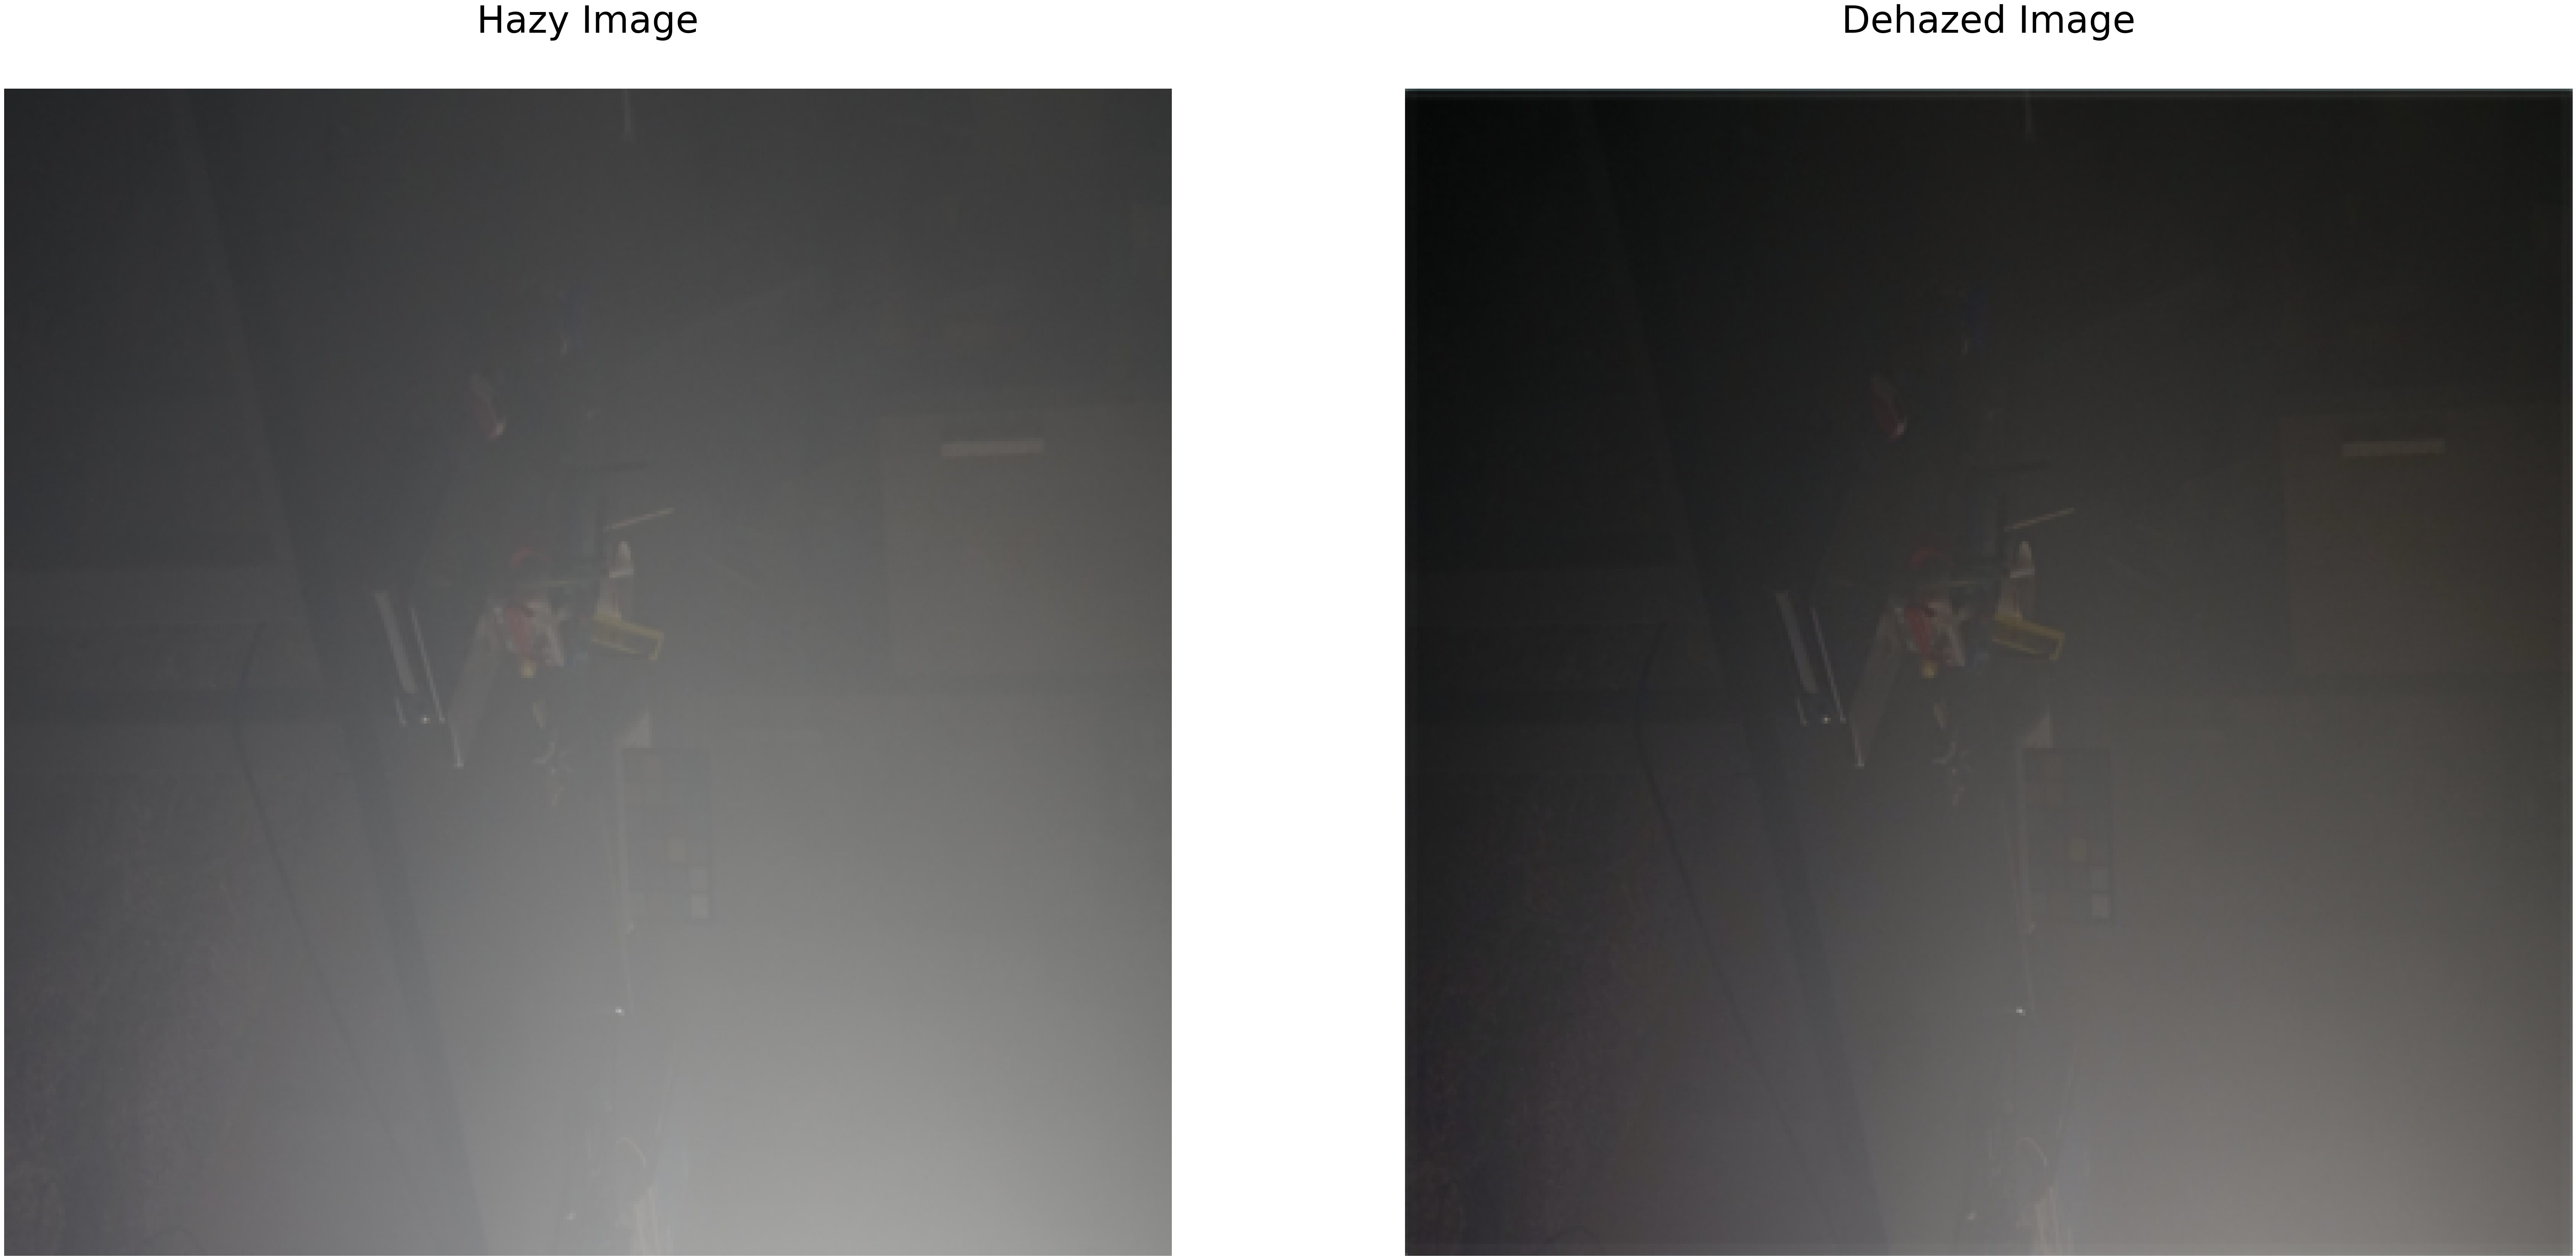

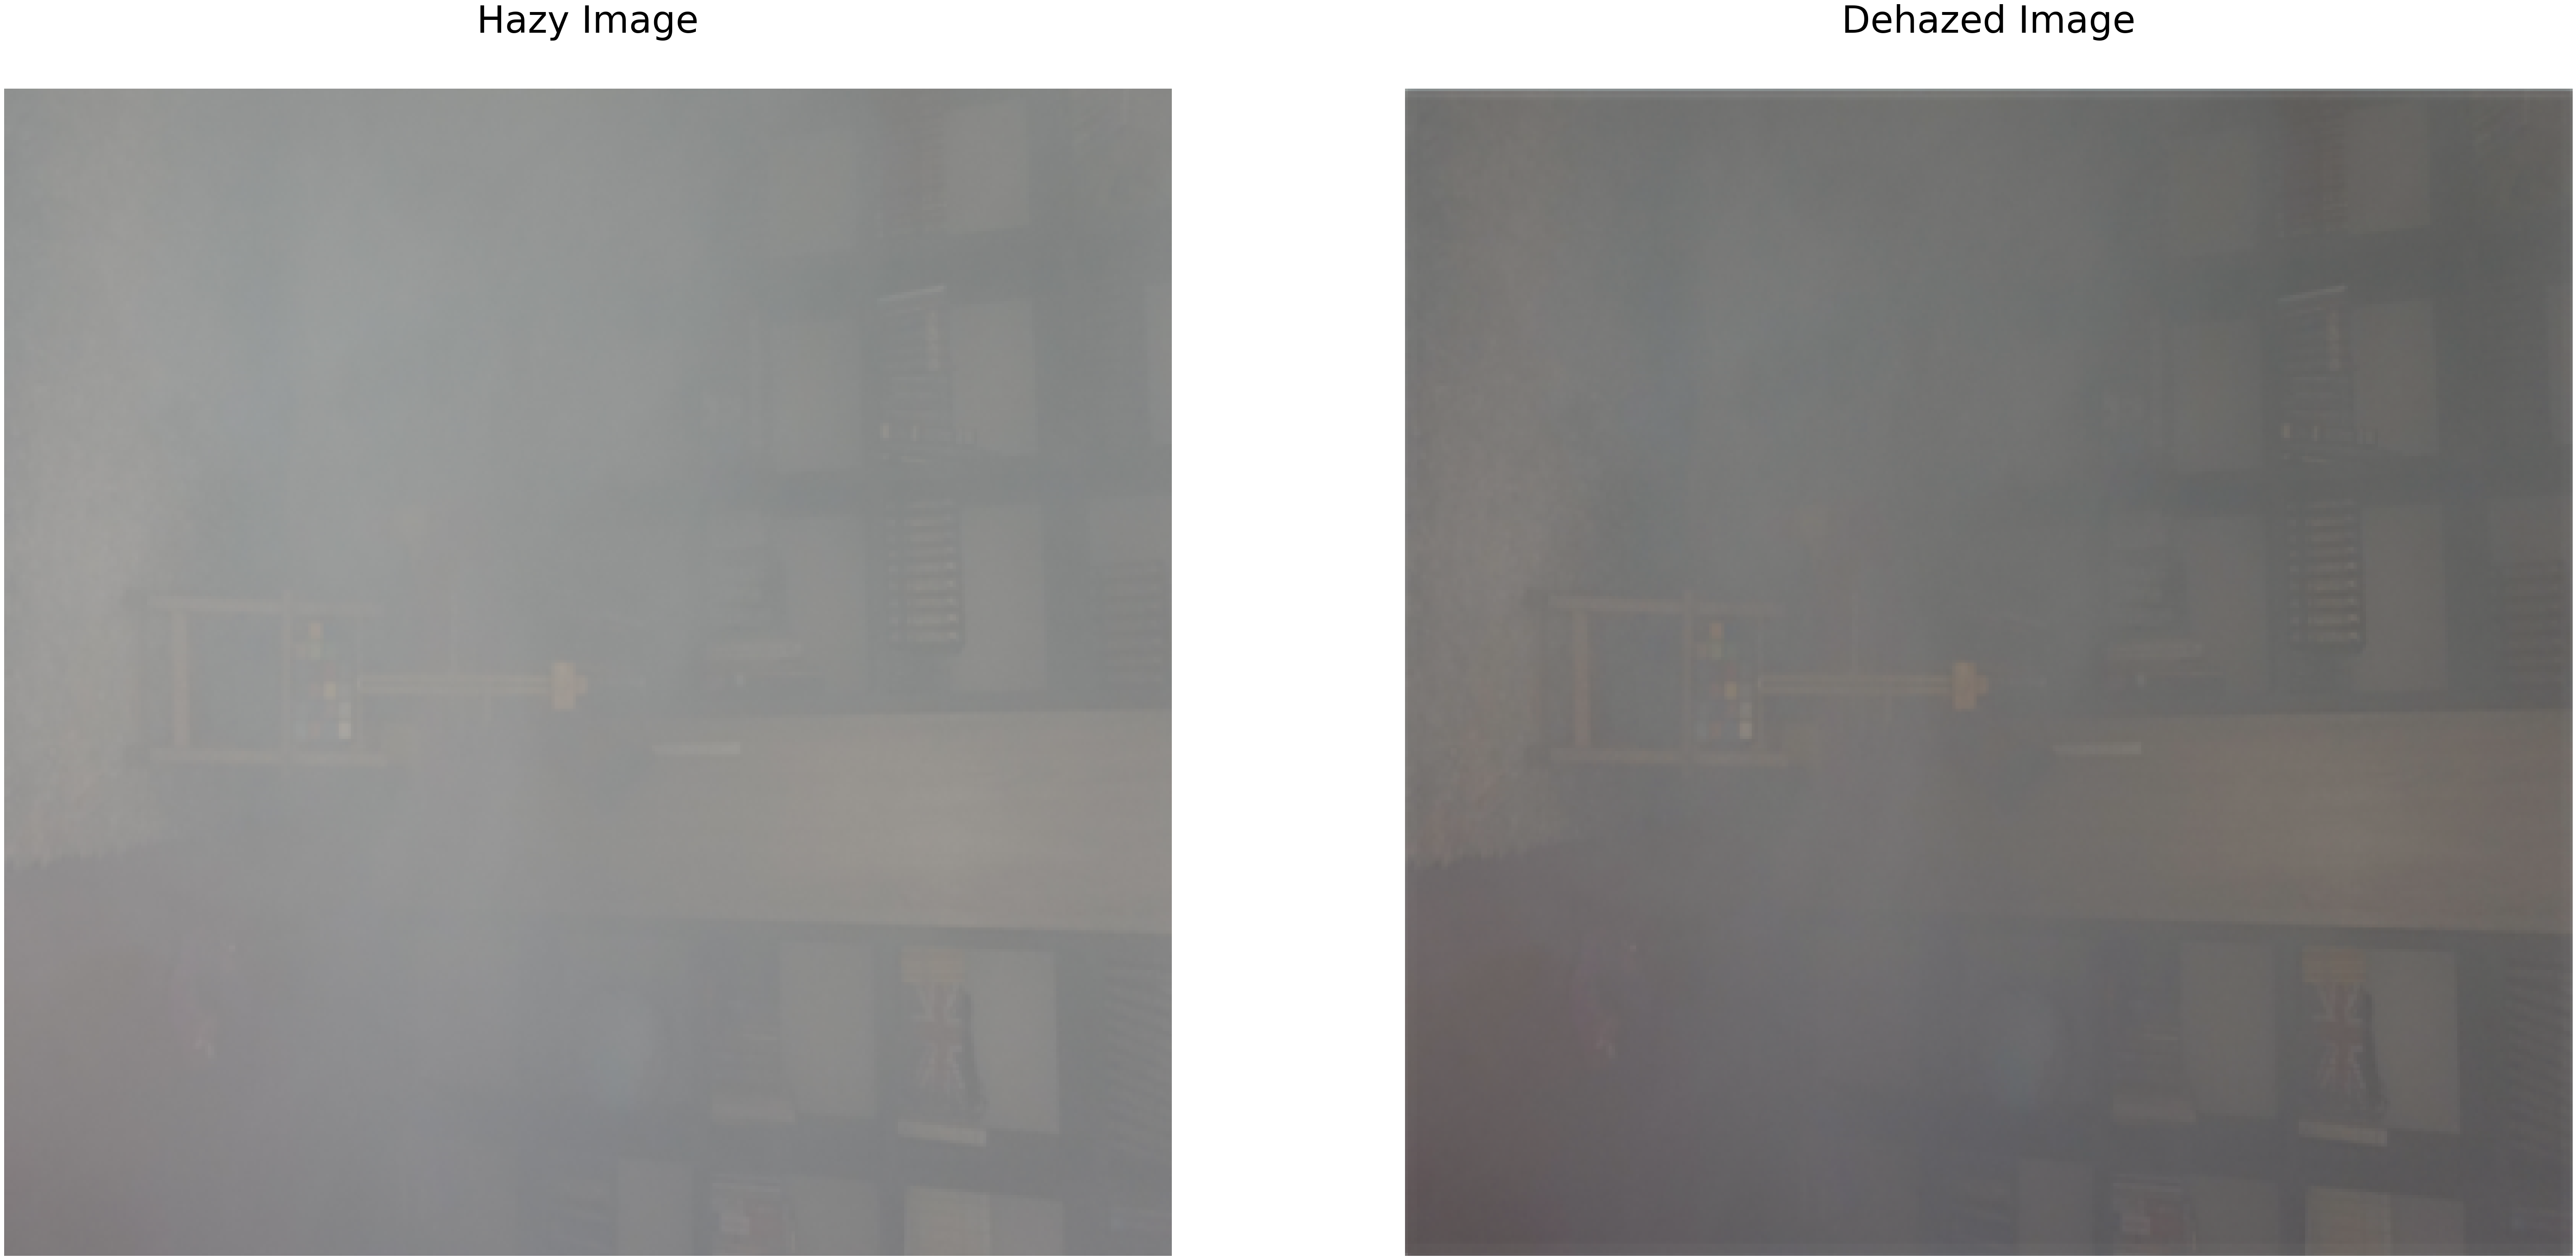

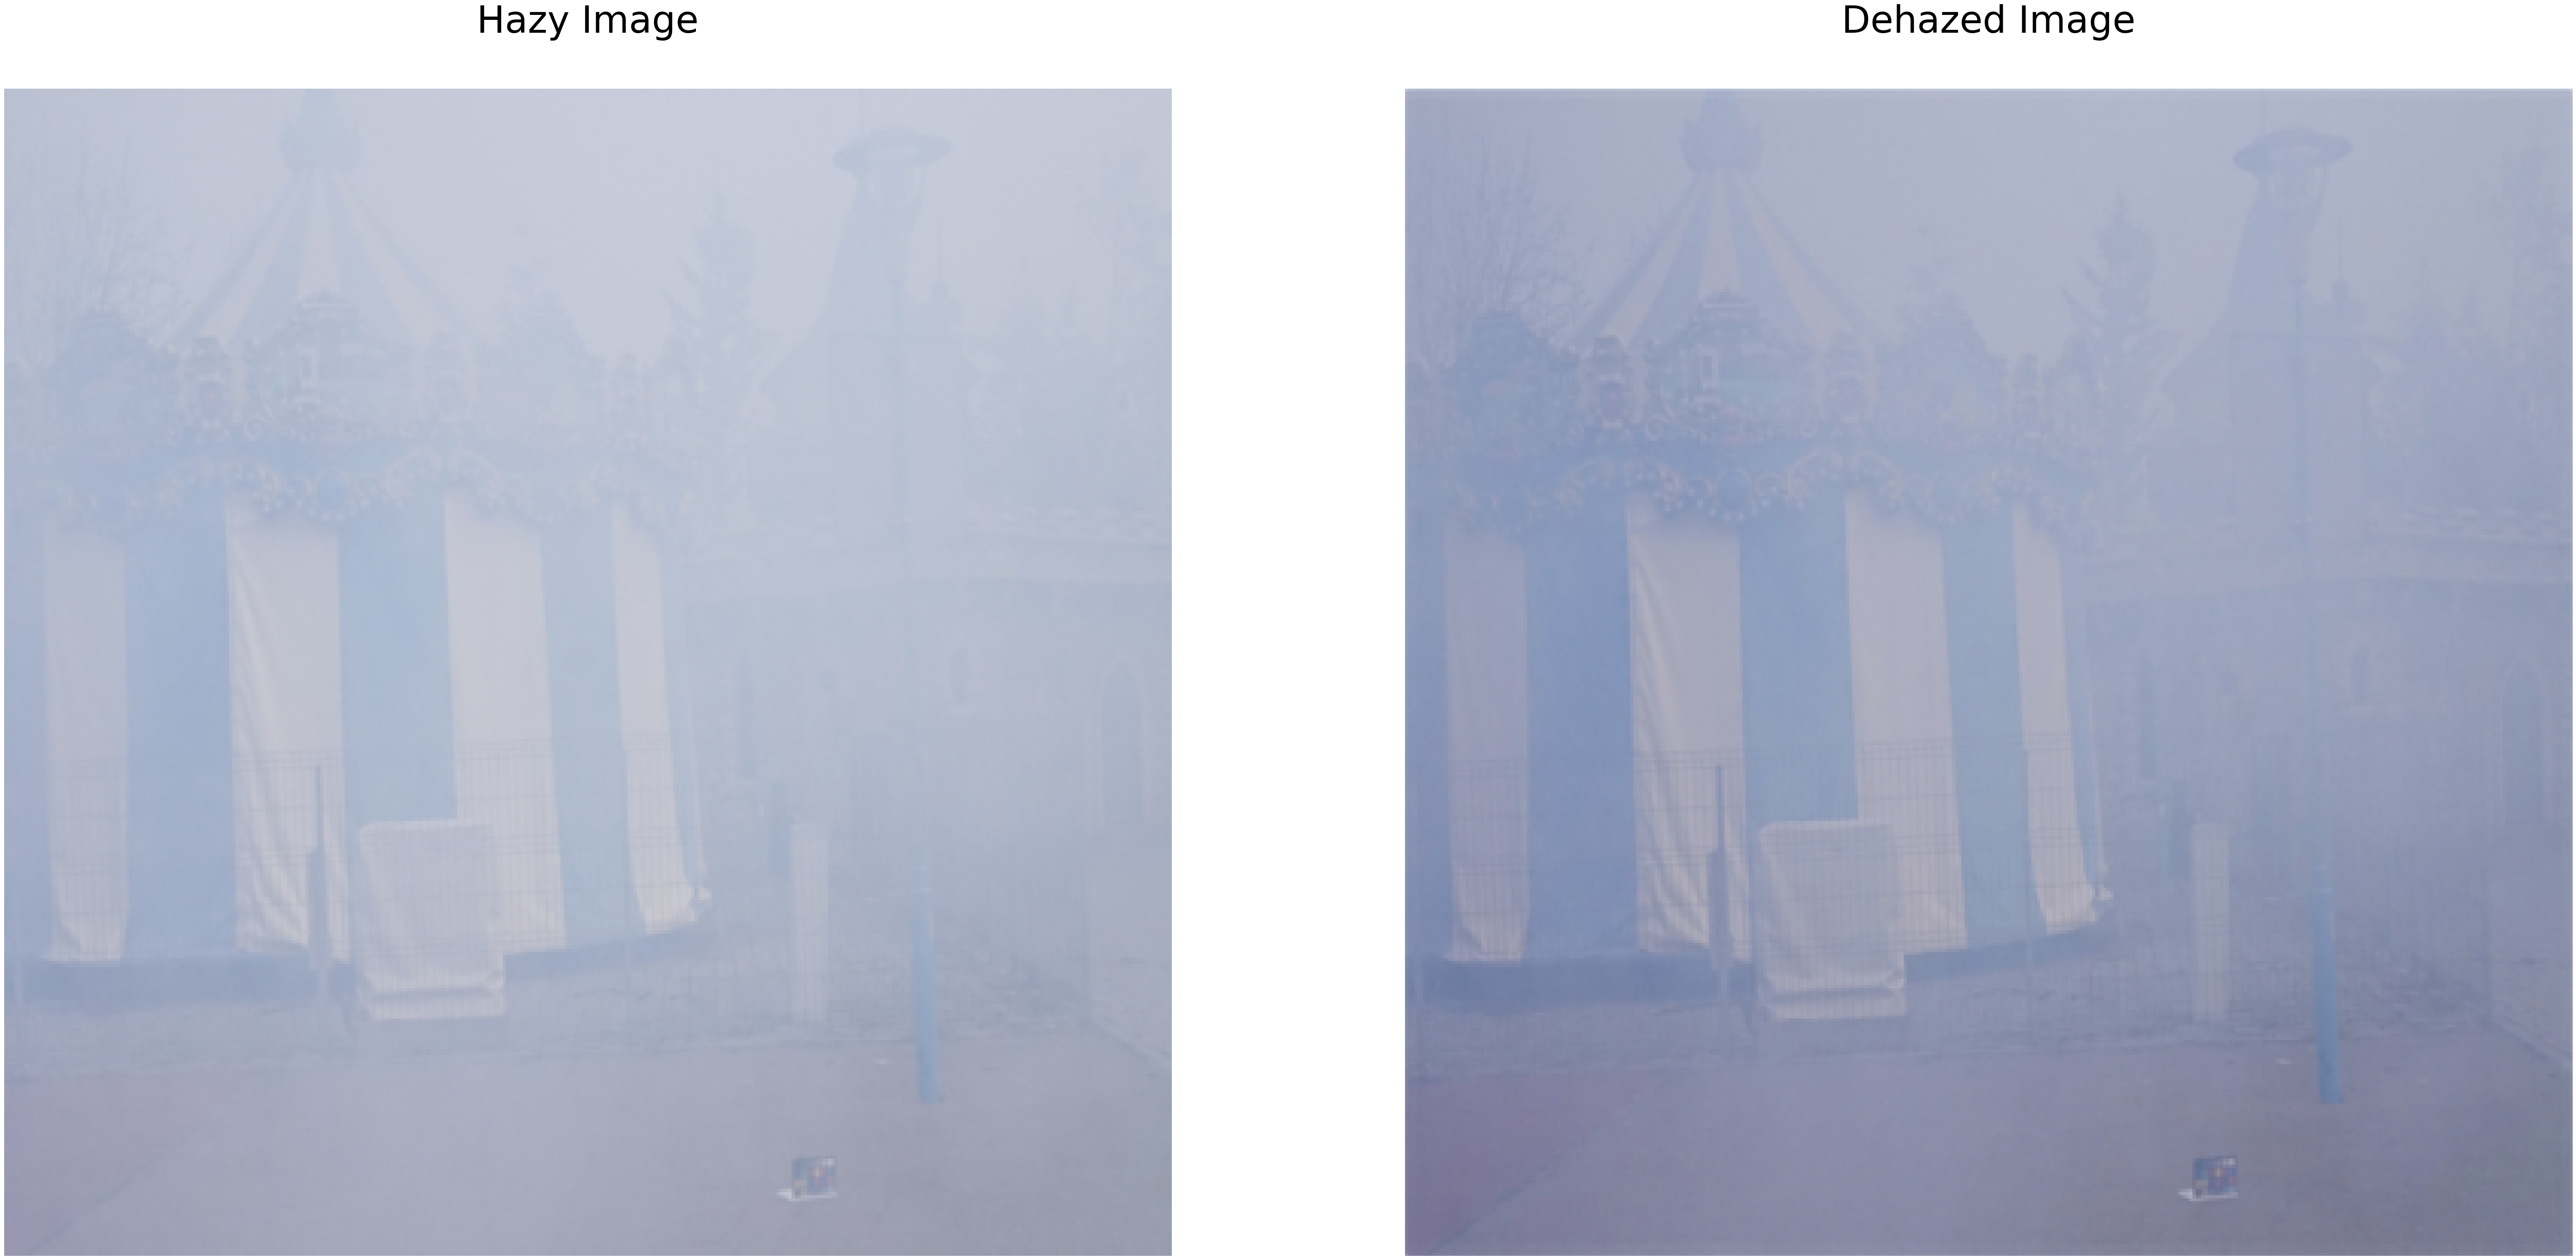

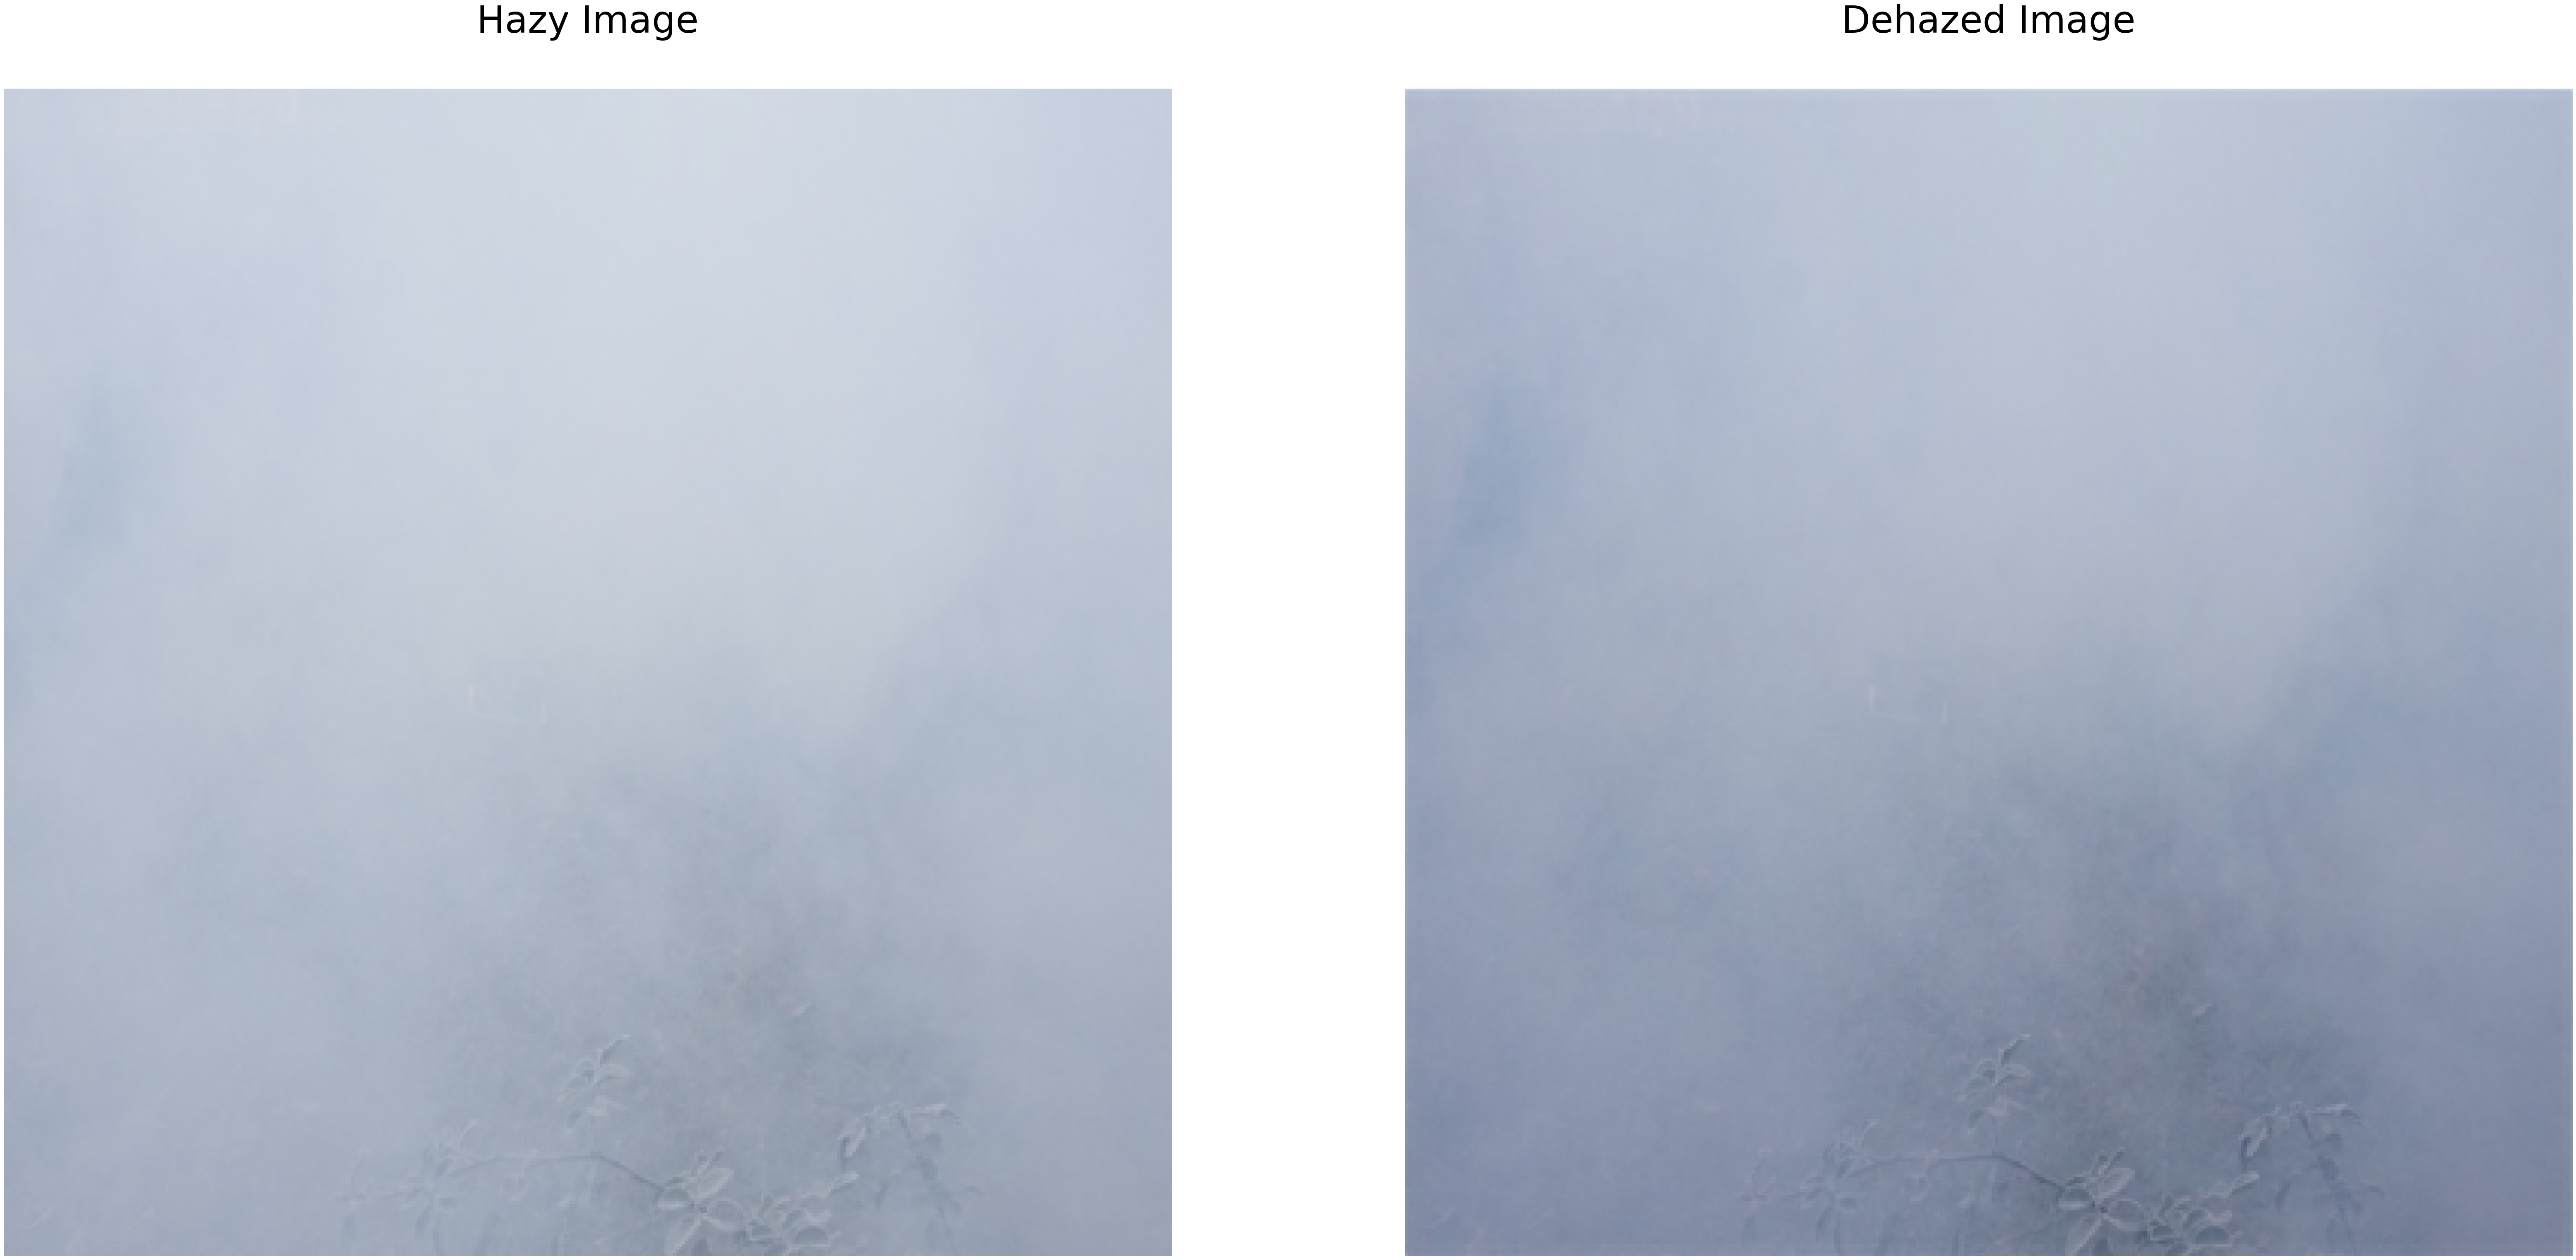

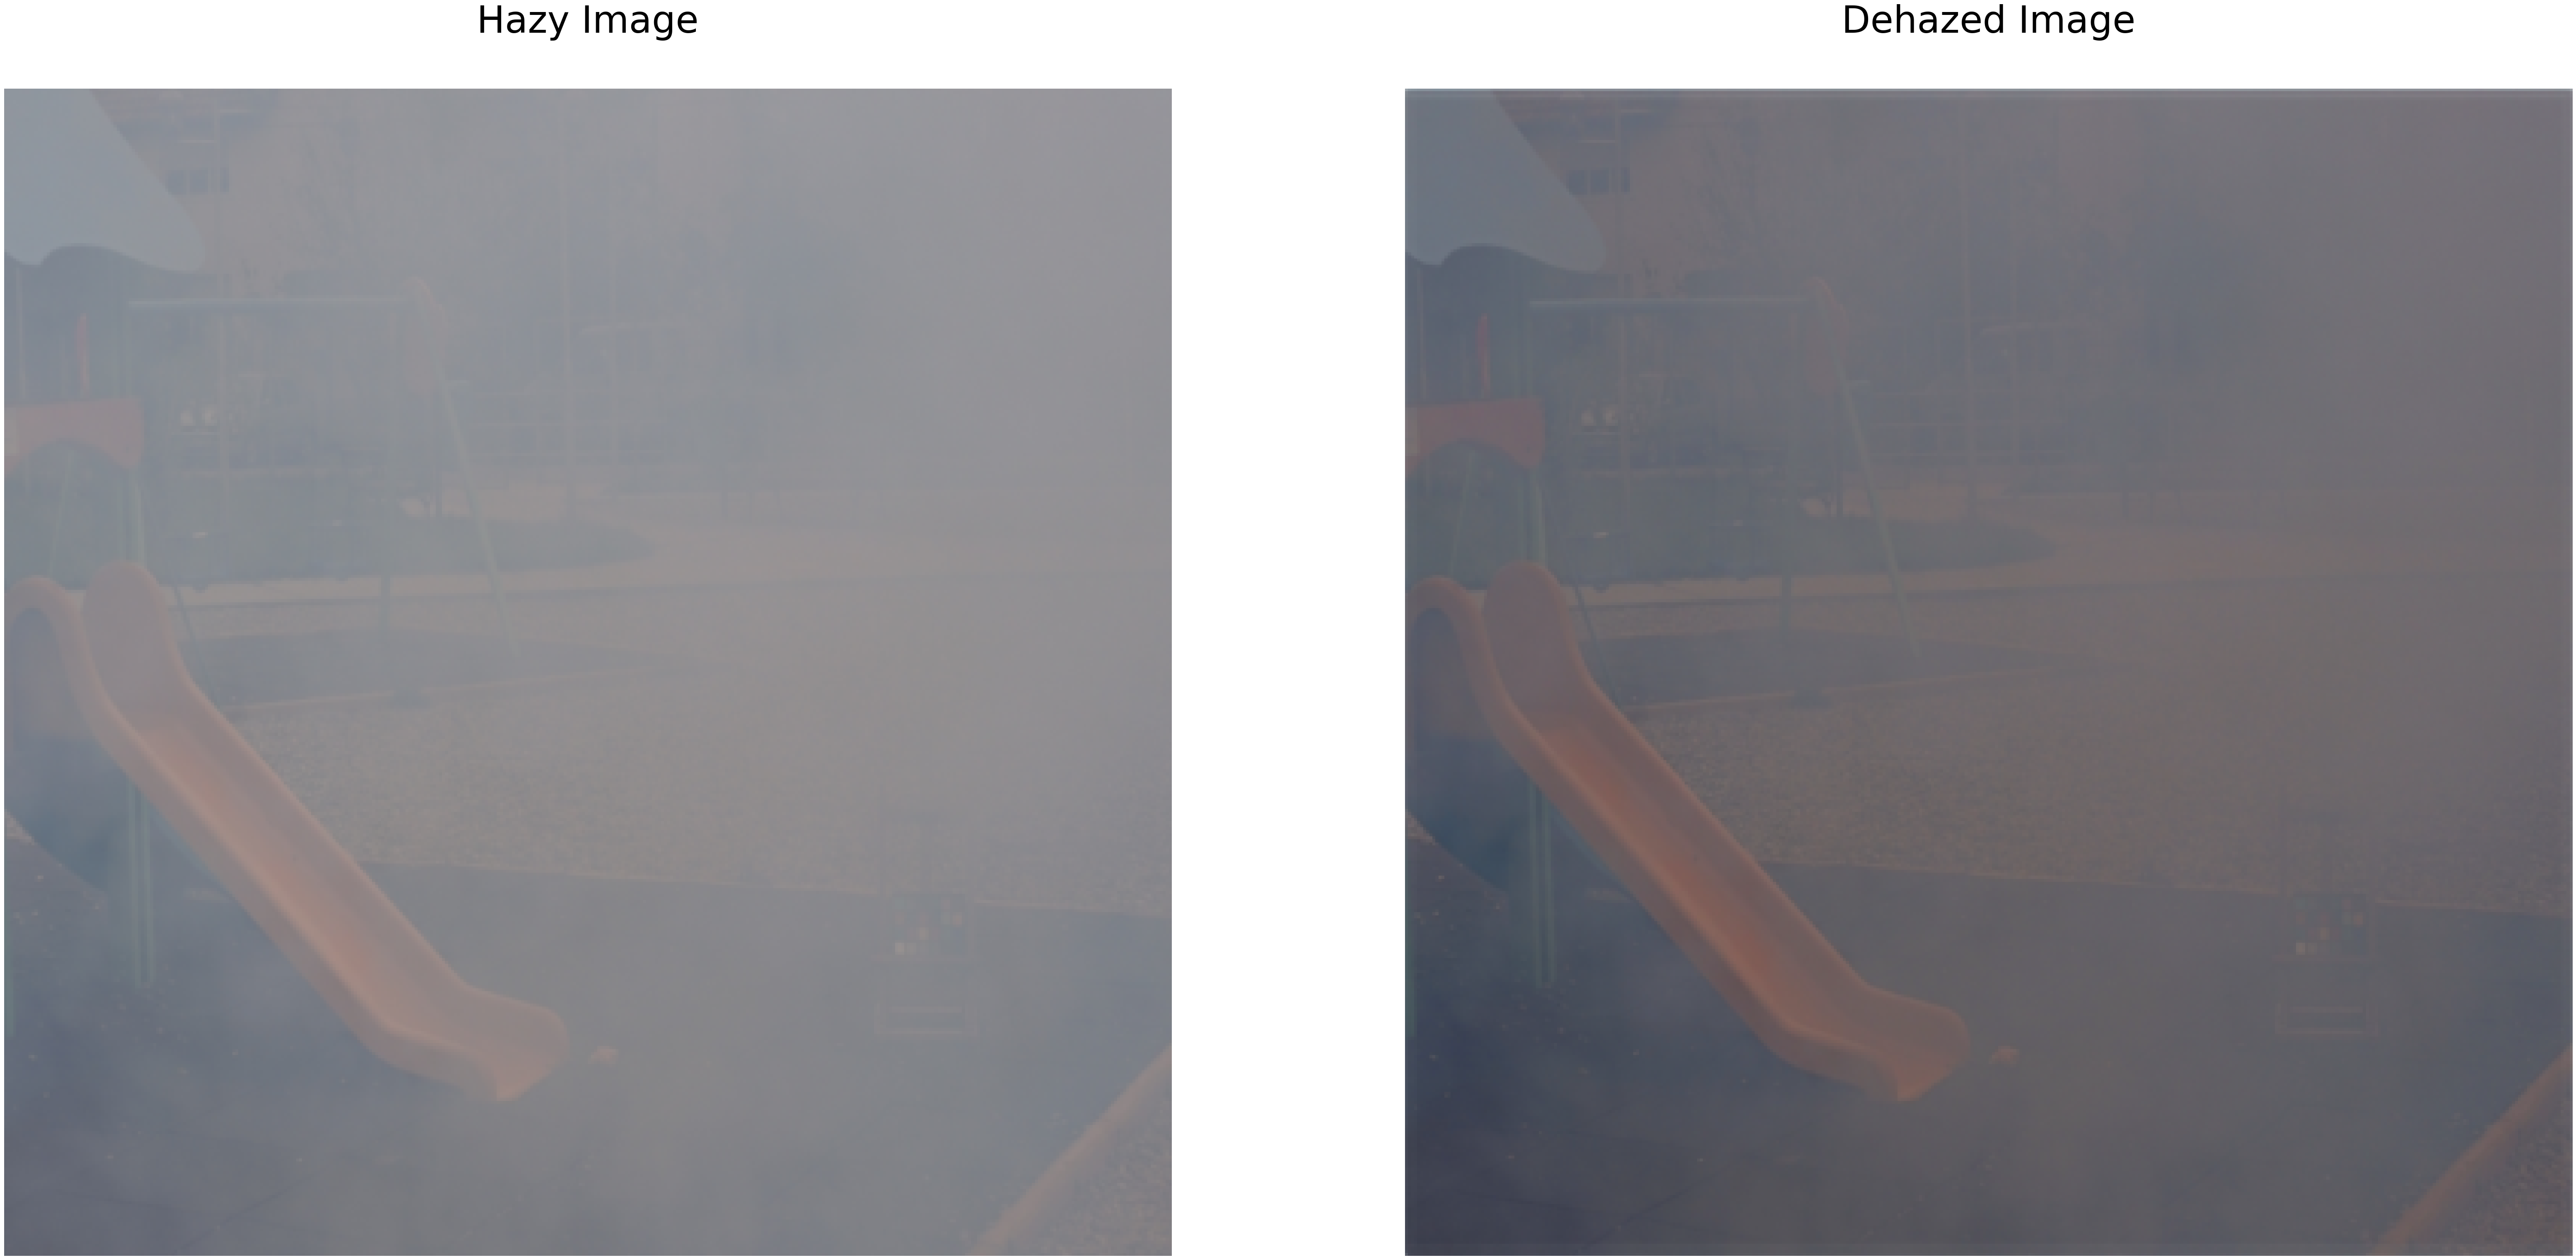

In [65]:
file_location = r"C:\Users\ASUS\Downloads\Video\RESULT"
test_net = tf.keras.models.load_model(r"C:\Users\ASUS\Downloads\Video\haze_net_trained2", compile = True)
output = evaluate(test_net, r"C:\Users\ASUS\Downloads\Video\Dense-Haze-V\IN",file_location)

In [2]:
import cv2
import os
test_clr_dir = r"C:\Users\ASUS\Downloads\test_clear2"
test_haze_dir = r"C:\Users\ASUS\Downloads\test_hazy2"
result_dir = r"C:\Users\ASUS\Downloads\result"

height, width = 384, 384

feature_test = []
label_test = []
pred_images = [] 

# Get the list of files in the directories
test_clr_files = os.listdir(test_clr_dir)
test_haze_files = os.listdir(test_haze_dir)
pred_images_files = os.listdir(result_dir)

# Sort the files to ensure corresponding images are matched
test_clr_files.sort()
test_haze_files.sort()
pred_images_files.sort()

# Iterate through the files and process corresponding images
for clr_file, haze_file in zip(test_clr_files, test_haze_files):
    clr_img_path = os.path.join(test_clr_dir, clr_file)
    haze_img_path = os.path.join(test_haze_dir, haze_file)
    
    # Load and preprocess images using OpenCV
    clr_img = cv2.imread(clr_img_path)
    haze_img = cv2.imread(haze_img_path)
    clr_img = cv2.resize(clr_img, (height, width))
    haze_img = cv2.resize(haze_img, (height, width))
    
    # Normalize pixel values to [0, 1] range
    clr_img = clr_img.astype('float32') / 255.0
    haze_img = haze_img.astype('float32') / 255.0
    
    # Append the preprocessed images to feature_test and label_test
    feature_test.append(haze_img)
    label_test.append(clr_img)

for pred_img in pred_images_files:
    pred_img_path = os.path.join(result_dir,pred_img)
    pr_img = cv2.imread(pred_img_path)
    pr_img = cv2.resize(pr_img,(height, width))
    pr_img = pr_img.astype('float32')/255.0

    pred_images.append(pr_img)


# Now you can proceed with model evaluation or any other task

In [ ]:
test_net.compile(loss = 'mean_squared_error' , optimizer = optimizer, metrics=['accuracy'])

# Reshape the arrays to match the expected input shape
feature_test_array = np.expand_dims(feature_test_array, axis=0)  # Add batch dimension
label_test_array = np.expand_dims(label_test_array, axis=0)  # Add batch dimension

# Evaluate the model
losses = []
accuracyy = []
for clr_file, haze_file in zip(feature_test, label_test):
    loss, accuracy = test_net.evaluate(feature_test, label_test)
    losses.append(loss)
    accuracyy.append(accuracy)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(net, show_shapes = True, show_layer_names = True)